# 03. PyTorch Computer Vision Exercises

## 1. What are 3 areas in industry where computer vision is currently being used?

Three areas where Computer Vision is currently being used are:
* Automated self driving cars like Waymo and tesla.
* Cancer research with models being developed to destinguish healthy versus dangerous cells.
* Military, with applications such as mass surveliance and targeted weapons.

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

Overfitting in essence is the inability for a model to do well on new unseen data while simultanously preforming well on the trained data.

Why does overfitting occur?
* Overfitting occurs when the model does not learn to "generalize" the data but rather learns to "memorize" the training data resulting in only inputs similar to the training data giving a true positive.

What causes overfitting?
* The training data was too small, not giving the model enough data to learn enough possible inputs.
* The training data was not clean enough with too much "noisy" data, veracity was not maintained.
* The model trained too long, "memorizing" the training data.
* The model is too complex, it learns the "noise" in the data.

What are examples of overfitting?
* An example would be a model learning to identify dogs, if only pictures from dog parks where used the model may learn to associate grass with dogs, becoming unable to distinguish dogs in an environment without grass.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

Overfitting can be prevented in a few simple ways, some simple, some more complex.
1. Overfitting can be prevented by simply augmenting the training data to some extent in each epoch by flipping the image or reversing it.
2. Overfitting can be prevented with a technique known as pruning, where you teach to ignore some paramters in the model to keep only the most important and get rid of some "noise", like in the ability to distinguish cats from dogs you may want the model to ignore the fur or tail and focus on the face and ears.
3. Overfitting can be mitigated by the process of ensembling, where multiple models come together to create one unanimous output, only selecting the most accurate output.

## 4. Spend 20-minutes reading and clicking through the CNN Explainer website.

### * Upload your own example image using the "upload" button and see what happens in each layer of a CNN as your image passes through it.


Computer vision "sees" via a kernel examining each pixel in an input image & extracting data from it in the form of a tensor for each color channel, 3 for R.G.B.

Each output (3 in this case) are added together with a bias before being passed to the first `nn.Conv2d` layer. This is repeated with every other layer adding in a `nn.MaxPool2d` to compress the image so the model can learn to generalize.



## 5. Load the `torchvision.datasets.MNIST()` train and test datasets.

In [2]:
# PyTorch imports
import torch
from torch import nn

# Computer vision imports
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Data loader imports
from torch.utils.data import DataLoader

# Visualization imports
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy

# Timing imports
from timeit import default_timer as timer
from tqdm.auto import tqdm



# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# load FashionMNIST datasets for training & testing

train_data = datasets.FashionMNIST(
    root='data', # What directory to download data to
    train=True, # Do we want the training data set
    download=True, # Do we want to download the data?
    transform=ToTensor(), # How do we want to transform the data?
    target_transform=None # How do we want to transform the labels/target?
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

## 6. Visualize at least 5 different samples of the MNIST training dataset.

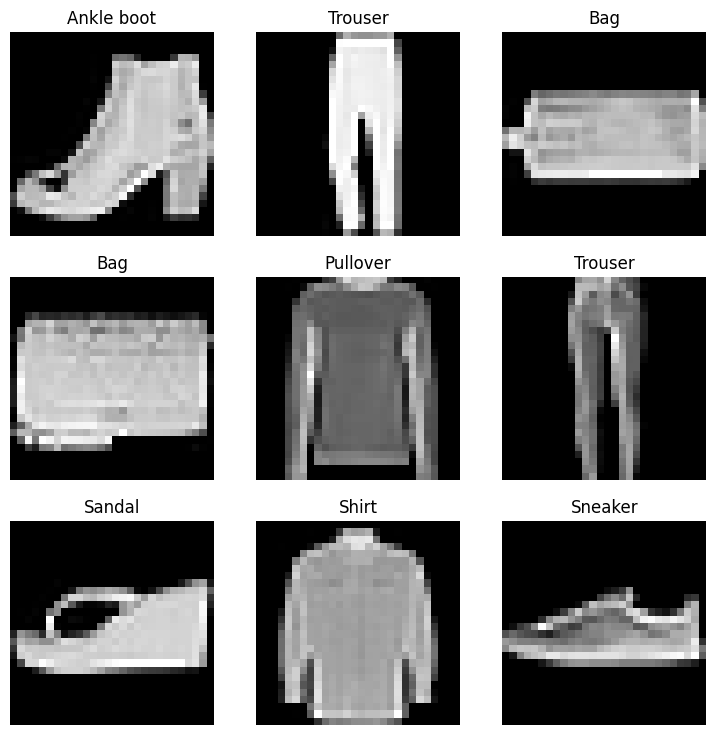

In [4]:
fig = plt.figure(figsize=(9, 9)) # figure(figsize=(width & height in inches))
rows, cols = 3, 3
class_names = train_data.classes

for i in range (1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item() # random int between 0 and 60,000, as a 1D tensor (scalar) & convert to python int
    img, label = train_data[random_idx] # get the image and label for the random index

    fig.add_subplot(rows, cols, i) # creates a 3x3 subplot as defined by rows & cols
    plt.imshow(img.squeeze(), cmap='gray') # plot the random image in greyscale, squeeze() removes the extra dimension
    plt.title(class_names[label]) # plot the label of the class by indexing the class_names list
    plt.axis(False)


## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [5]:
# Bacth size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (i.e batches)
train_dataloader = DataLoader(
    dataset=train_data, # the dataset to learn from
    batch_size=BATCH_SIZE, # the size of each batch
    shuffle=True # shuffle the data so model doesnt learn order
)

test_dataloader = DataLoader(
    dataset=test_data, 
    batch_size=BATCH_SIZE,
    shuffle=False # False here as data learned without order, so no need to shuffle & maintains reproducibility
)

In [6]:
# Visualize the dataLoaders numbers
print(f"{len(train_dataloader)} | Batches of: {BATCH_SIZE}")
print(f"{len(test_dataloader)} | Batches of: {BATCH_SIZE}")

1875 | Batches of: 32
313 | Batches of: 32


## 8. Recreate `model_2` used in this notebook (the same model from the CNN Explainer website, also known as TinyVGG) capable of fitting on the MNIST dataset.

In [7]:
class TinyVGG(nn.Module):
    def __init__(
            self,
            input_shape: int,
            hidden_units: int,
            output_shape: int,
    ):
        super().__init__()
        ### Convolutional Layers
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        ### Flatten layer
        self.flatten_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*49, # may have to alter to fit requirements for matmul
                      out_features=output_shape) # how many labaels/classes in the dataset
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.flatten_layer(x)
        return x


model_VGG = TinyVGG(
    input_shape=1, # int is how many color channels (e.g 1 for grayscale, 3 for RGB)
    hidden_units=10, # int is the number of hidden units/neurons in each layer
    output_shape=len(class_names)
).to(device)


## 9. Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.

In [8]:
# loss, optimzer, accuracy
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_VGG.parameters(),
                            lr=0.1)
accuracy = MulticlassAccuracy(num_classes=len(class_names)).to(device)


In [9]:
def train_loop(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy,
               device: torch.device = device):
    ### Training mode

    model.train()

    # Initalize loss & accuracy
    train_loss = 0
    train_acc = 0

    ### Loop through the training batches
    for batch, (X, y) in enumerate(data_loader): # for (FEATURES, labels). enumerate loops through the batches to keep track of how many batches have been looped through.\
        # Put data on target device
        X = X.to(device)
        y = y.to(device)
        model.to(device)

        # Forward pass
        y_logits = model(X) # logits
        y_probs = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the loss (and accuracy)
        loss = loss_fn(y_logits, y)
        train_loss += loss

        train_acc += accuracy(y_probs, y)*100

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward (back propagation)
        loss.backward()

        # Optimizer step
        optimizer.step()

    # Evaluate the loss & accuracy
    train_loss /= len(data_loader) # train loss / number of batches (1875 batches of 32)
    train_acc /= len(data_loader) 

    # Print out whats happening
    print(f"Train loss: {train_loss:.4f} | Train accuracy {train_acc:4f}%")

In [10]:
def test_loop(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy,
              device: torch.device = device):
    ### Testing mode
    model.eval()
    with torch.inference_mode():
        # Initialize loss & accuracy
        test_loss = 0
        test_acc = 0

        # Loop through testing batches
        for X, y in data_loader: # for (FEATURES, labels) in 313 batches (of 32)
            # Put data on target device
            X = X.to(device)
            y = y.to(device)
            model.to(device)

            # Forward pass
            y_logits = model(X)
            y_probs = torch.softmax(y_logits, dim=1).argmax(dim=1)

            # Calculate the loss (& accuracy)
            loss = loss_fn(y_logits, y)
            test_loss += loss

            test_acc += accuracy(y_probs, y)*100

        # Evaluate the loss & accuracy
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        # Print out whats happening
        print(f"Test loss: {test_loss:.4f} | Test accuracy {test_acc:4f}%")

In [11]:
def measure_time(start: float,
                 stop: float,
                 device: torch.device = device):
    final_time = stop - start
    print(f"Total Time on {device}: {final_time:.4f} seconds")
    return final_time

In [12]:
torch.manual_seed(1337)

# Measure time
time_start = timer()

# Loops through data
epochs = 3

# train & test loop
for epoch in tqdm(range(epochs)):
    print(f"\nEpoch {epoch}\n-------------------------------")

    train_loop(
        model=model_VGG,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy=accuracy.to('cuda'),
        device='cuda'
    )

    test_loop(
        model=model_VGG,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy=accuracy.to('cuda'),
        device='cuda'
    )

# Measure final time
time_end = timer()
total_time = measure_time(start=time_start,
                              stop=time_end,
                              device=str(next(model_VGG.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch 0
-------------------------------
Train loss: 0.6465 | Train accuracy 75.574379%
Test loss: 0.4147 | Test accuracy 84.444565%

Epoch 1
-------------------------------
Train loss: 0.3522 | Train accuracy 86.504395%
Test loss: 0.3622 | Test accuracy 85.992470%

Epoch 2
-------------------------------
Train loss: 0.3199 | Train accuracy 87.497566%
Test loss: 0.3211 | Test accuracy 87.553139%
Total Time on cuda:0: 30.1280 seconds


In [13]:
# torch.manual_seed(1337)

# # Measure time
# time_start = timer()

# # Loops through data
# epochs = 3

# # train & test loop
# for epoch in tqdm(range(epochs)):
#     print(f"\nEpoch {epoch}\n-------------------------------")

#     train_loop(
#         model=model_VGG,
#         data_loader=train_dataloader,
#         loss_fn=loss_fn,
#         optimizer=optimizer,
#         accuracy=accuracy.cpu(),
#         device="cpu"
#     )

#     test_loop(
#         model=model_VGG,
#         data_loader=test_dataloader,
#         loss_fn=loss_fn,
#         accuracy=accuracy.cpu(),
#         device="cpu"
#     )

# # Measure final time
# time_end = timer()
# total_time = measure_time(start=time_start,
#                               stop=time_end,
#                               device="cpu")

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

In [14]:
def make_preds(model: torch.nn.Module,
               data: list,
               device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Pred sample
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass
            pred_logit = model(sample)

            # Get prod probs from logits
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Put on CPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack pred_probs to turn list into tensor
    return torch.stack(pred_probs)
    

In [130]:
import random
#random.seed(1337)

test_samples = []
test_labels = []

# Picks 9 radom samples & its label from test_data list then appends both to each list
for sample, label in random.sample(list(test_data), k=9): 
    test_samples.append(sample)
    test_labels.append(label)

print(test_samples[0].shape)
print(test_labels)

torch.Size([1, 28, 28])
[0, 3, 7, 5, 8, 0, 9, 0, 3]


In [131]:
predictions = make_preds(model=model_VGG,
                        data=test_samples)

predictions[0]

tensor([1.0049e-01, 5.2870e-05, 3.1138e-01, 1.7451e-02, 2.6717e-02, 5.5397e-06,
        5.4316e-01, 5.3099e-06, 7.1657e-04, 1.5890e-05])

In [132]:
prediction_labels = torch.argmax(predictions, dim=1)
prediction_labels

tensor([6, 3, 7, 5, 8, 0, 9, 0, 3])

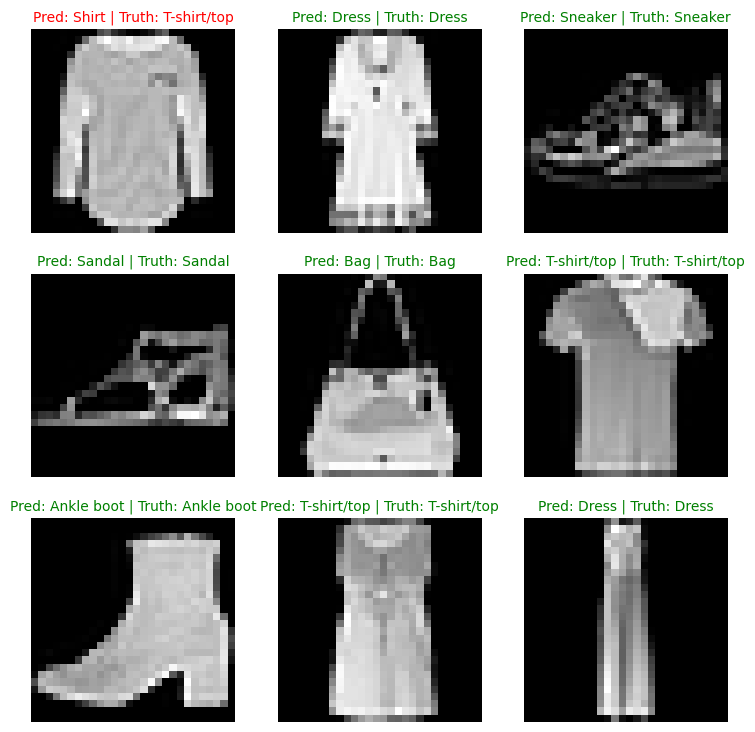

In [133]:
# Plot predictions

fig = plt.figure(figsize=(9, 9))
rows = 3
cols = 3

for i, sample in enumerate(test_samples):
    # Create subplot 3x3 starting from index 1
    plt.subplot(rows, cols, i+1)

    # plot the image 
    plt.imshow(sample.squeeze(), cmap="grey")

    # find pred label for the image (e.g "Sandal")
    pred_label = class_names[prediction_labels[i]]

    # get the true label
    true_label = class_names[test_labels[i]]

    # create the title
    title_text = f"Pred: {pred_label} | Truth: {true_label}"

    if pred_label == true_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis("off")

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [134]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm

# make preds with trained model
y_preds = []

model_VGG.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send data to target device
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        y_logits = model_VGG(X)

        # logits -> probs
        y_probs = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)

        # Put on CPU for eval
        y_preds.append(y_probs.cpu())

# concat list of preds into tensor
y_preds_tensor = torch.cat(y_preds)
y_preds_tensor


Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 8])

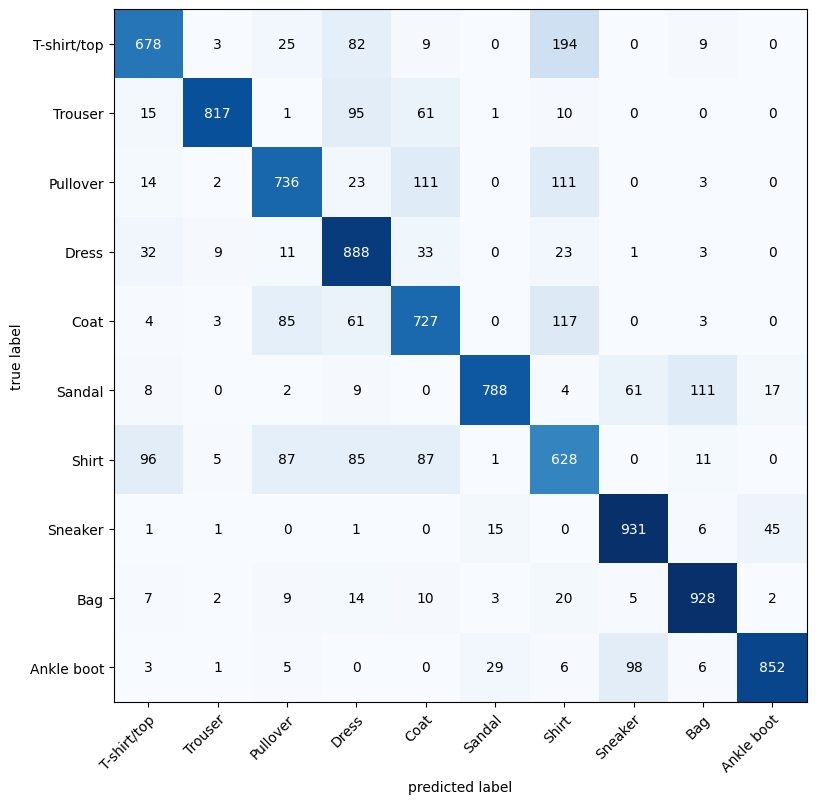

In [135]:
# Initiate confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds_tensor,
                         target=test_data.targets)

# plot the matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib needs a NumPy array, not a tensor
    class_names=class_names,
    figsize=(9,9)
)

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [136]:
# Random tensor
Tensor = torch.Tensor(1, 1, 64, 64)

Tensor.shape

torch.Size([1, 1, 64, 64])

In [137]:
conv = nn.Conv2d(in_channels = 1,
          out_channels=1,
          kernel_size = 3,
          stride = 1,
          padding = 1)

conv(Tensor).shape

torch.Size([1, 1, 64, 64])

* `Kernel_size` adjusts the height * width of the tensor. Higher `kernel_size` increases height * wigth linearly.

## 13. Use a model similar to the trained `model_2` from this notebook to make predictions on the test `torchvision.datasets.FashionMNIST` dataset.

### * Then plot some predictions where the model was wrong alongside what the label of the image should've been.
### *After visualizing these predictions do you think it's more of a modelling error or a data error?
### *As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?


* ### I believe that it is 50/50 with the few tests I have done. out of 4-5 errors, 2-3 of them were labeling errors (e.g shirt listen as T-shirt/top) while the remaining errors were simply incorrect (e.g pullover listen as bag)